In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.constants as cons
from openpmd_viewer import OpenPMDTimeSeries
from openpmd_viewer import ParticleTracker
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
q_e = cons.elementary_charge
m_e = cons.electron_mass
epsilon0 = cons.epsilon_0
clight = cons.speed_of_light
pi = cons.pi

########################################################################
def add_colorbar(im, width=None, pad=None, **kwargs):
    l, b, w, h = im.axes.get_position().bounds       # get boundaries
    width = width or 0.05 * w                         # get width of the colorbar
    pad = pad or width                               # get pad between im and cbar
    fig = im.axes.figure                             # get figure of image
    cax = fig.add_axes([l + w + pad, b, width, h])   # define cbar Axes
    return fig.colorbar(im, cax=cax, **kwargs)       # draw cbar
########################################################################

def laser_plasma_para(lam,dens,a0):
    # From the wavelength calculate laser frequency
    w_l = (2*pi*clight)/lam
    # From laser frequency calculate critical density m^-3
    nc = (epsilon0*m_e/q_e**2)*w_l**2       
    # Density in terms of the critical density 1/m^3
    ne_0 = dens*nc       # density in terms if critical ~3.5e18 cm^3
    # density in 1/cm^3
    ne_0_cm3 = ne_0*(1/100)**3
    # From the plasma density calculate plasma frequency
    wp = ((ne_0*q_e**2)/(m_e*epsilon0))**(1/2)  
    # From Plasma frequency calculate plasma wavelength         
    lam_p = (2*pi*clight)/wp                           
    # From plasma wavelength calculate plasma wavenumber
    kp = (2*pi)/lam_p                                      
    # from a0, wavelength, and density calculate dephasing length
    Ld = (2/(3*pi))*(a0)**(1/2)*lam*(nc/ne_0)**(3/2)      
    # from a0 and wavenumber calculate matched spot size
    w0 = (2*(a0)**(1/2)) / kp                           
    # from a0 and wavenumber calculate matched pulse duration
    tauFWHM = ((2*(a0)**(1/2)) / kp) * (1/clight)       \
    # Group velocity normalized to speed of light
    vg = (1 - (0.5*(ne_0/nc)))
    # Field normalization constant for a0         
    E_laser_norm = (2*pi*m_e*clight**2)/(q_e*lam)
    return {
        "lam":lam,
        "w_l": w_l,
        "nc": nc,
        "ne0": ne_0,
        "ne0_cm3": ne_0_cm3,
        "wp": wp,
        "lam_p": lam_p,
        "kp": kp,
        "Ld": Ld,
        "match_w0": w0,
        "match_tau": tauFWHM,
        "vg": vg,
        "Enorm": E_laser_norm,

    }

def sim_RZ_para(lam,r,z,ncells,mode,max_grid_size,gpus):
    zmin = z[0]
    zmax = z[1]
    z_dom = abs(zmin) + abs(zmax)
    r_dom = r
    r_cells = ncells[0]
    z_cells = ncells[1]

    dr = r_dom / r_cells
    dz = z_dom / z_cells
    multimode_coeffs = np.array([0.2105, 1.0, 3.5234, 8.5104, 15.5059, 24.5037])

    if mode < 7:
        multimode_alpha = multimode_coeffs[mode - 1]
    else:
        multimode_alpha = (mode - 1)**2 - 0.4
        
    dt = 1 / (np.sqrt(((1 + multimode_alpha)/ (dr)**2) + (1/(dz)**2))*clight)

    cells_per_lam_r = lam/dr
    cells_per_lam_z = lam/dz


    boxes_r = ncells[0]/max_grid_size[0]
    boxes_z = ncells[1]/max_grid_size[1]


    total_boxes = boxes_r*boxes_z
    max_boxes = gpus*8.0
    max_r_power = np.log(ncells[0])/(np.log(2))
    max_z_power = np.log(ncells[1])/(np.log(2))

    powers_r = np.arange(1,max_r_power,1)
    reverse_powers_r = powers_r[::-1]

    powers_z = np.arange(1,max_z_power,1)
    reverse_powers_z = powers_z[::-1]

    list_of_possible_breakdowns = []
    for i in reverse_powers_r:
        for j in reverse_powers_z:
            num_boxes_op = (ncells[0]/ 2**i) * (ncells[1]/2**j)
            if num_boxes_op == max_boxes:
                list_of_possible_breakdowns.append(("max grid r powers {}, max grid z powers {}".format(i,j)))

    

    return {
        "dr": dr,
        "dz": dz,
        "dt": dt,
        "res_r": cells_per_lam_r,
        "res_z": cells_per_lam_z,
        "boxes": total_boxes,
        'decompose':list_of_possible_breakdowns,
    }



In [2]:
path_Rz ='/Users/victorflores/warpx_env/WarpX/Runs_Rz/Laser_Test/diags/diag1'
data= OpenPMDTimeSeries("{}".format(path_Rz),backend="h5py")

In [3]:
# laser_plasma parameters
lam = 800e-9
dens = 0.0005
a0 = 2
lp_para = laser_plasma_para(lam,dens,a0)

lamp  = lp_para['lam_p']


In [4]:
lp_para['match_tau']

5.3721657912541126e-14

In [5]:
len(data.iterations)

12

In [25]:
j = 11
t=data.t[j]
Ey, Ey_info = data.get_field(t=data.t[j], field='E',coord="y", plot=False)
rho_ele, ele_info = data.get_field(t=data.t[j], field='rho_electrons', plot=False)
Ey_slice, Ey_info_slice = data.get_field(t=data.t[j], field='E',coord="y", plot=False, slice_across="r",slice_relative_position= 0)
Ez_slice, Ez_info_slice = data.get_field(t=data.t[j], field='E',coord="z", plot=False, slice_across="r",slice_relative_position= 0)
zmin = Ey_info.zmin
zmax = Ey_info.zmax
rmin = Ey_info.rmin
rmax = Ey_info.rmax
Ey_norm = Ey/lp_para['Enorm']
Ey_slice_norm = Ey_slice / lp_para['Enorm']
delta_tho_ele = ((-rho_ele/q_e) - lp_para['ne0'])/ (lp_para['ne0'])
Z = np.linspace(zmin, zmax, len(Ey))
R = np.linspace(rmin, rmax, len(Ey[0]))

In [26]:
lp_para['ne0']

8.709798563841332e+23

In [27]:
np.max(-rho_ele/q_e)

np.float64(5.2608467277256675e+25)

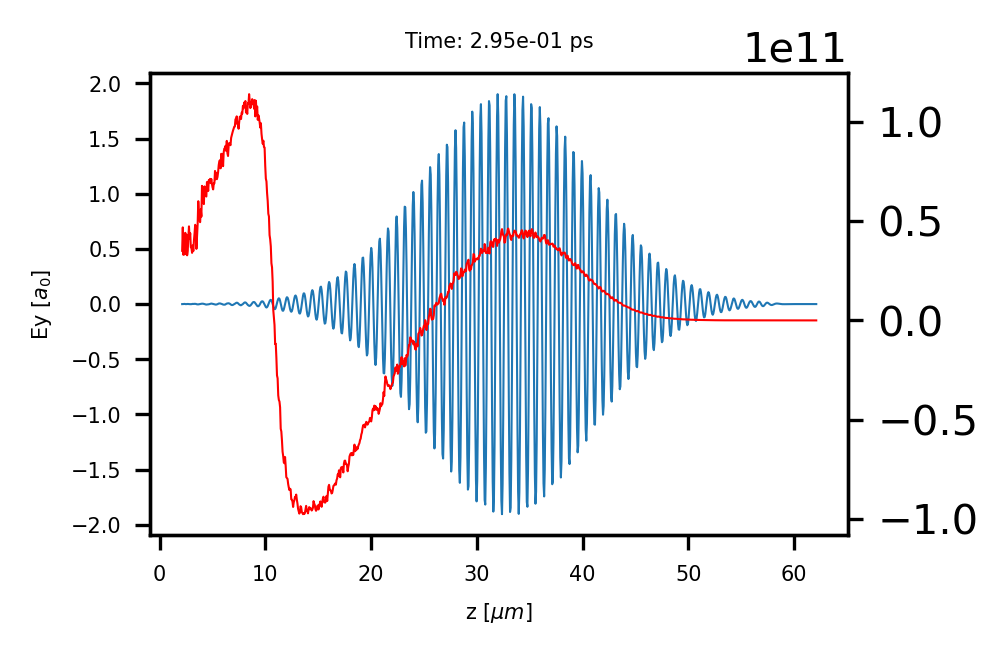

In [28]:
#####################################
fig_width = 3 # Set width to 1.5 inches
fig_height = 2  # Set height to 1.5 inches
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)
#charge_bg_dens = ax.pcolormesh(Z,X,rho_ele_dens.T,cmap='Spectral_r')
ax.plot(Z*10**6 , Ey_slice_norm, linewidth = 0.5)
ax2 = ax.twinx()
ax2.plot(Z*10**6 , Ez_slice, linewidth = 0.5,color='red')
ax.set_title('Time: {:.2e} ps'.format(t*10**12),fontsize=5)
ax.tick_params('x',labelsize=5)
ax.tick_params('y',labelsize=5)
ax.set_ylabel(r'Ey [$a_0$]', fontsize = 5)
ax.set_xlabel(r'z [$\mu m$]', fontsize = 5)
plt.show()

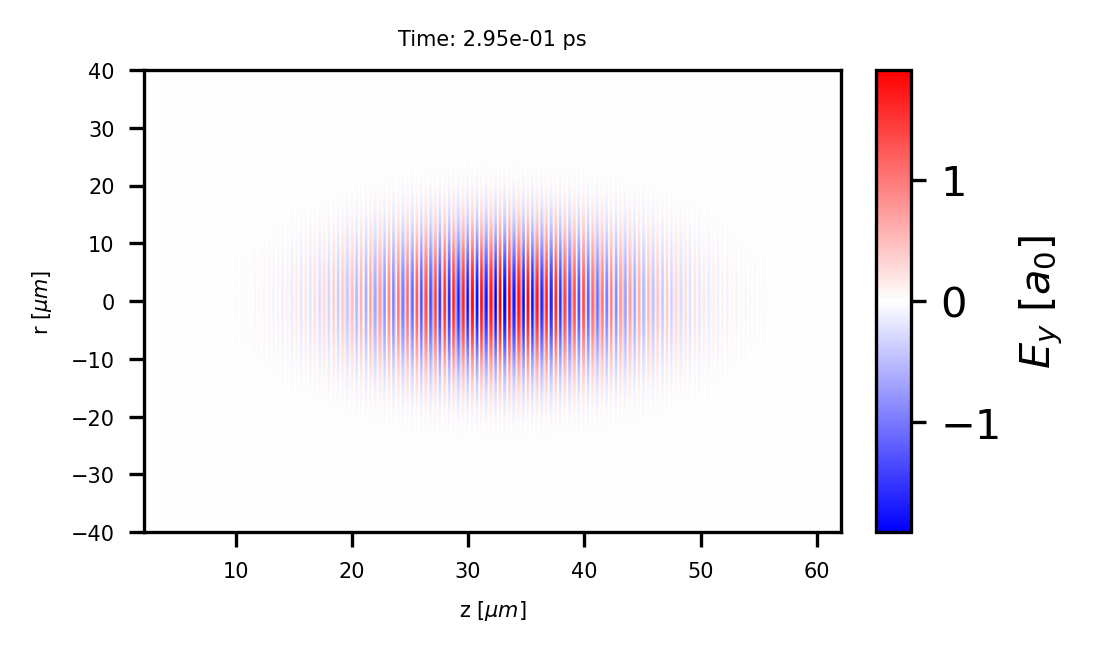

In [29]:
#####################################
fig_width = 3 # Set width to 1.5 inches
fig_height = 2  # Set height to 1.5 inches
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)
#charge_bg_dens = ax.pcolormesh(Z,X,rho_ele_dens.T,cmap='Spectral_r')
Ey_field = ax.pcolormesh(Z *10**6, R*10**6, Ey_norm.T, cmap='bwr')
cb1 = add_colorbar(Ey_field)
cb1.set_label('$E_y$ [$a_0$]')
ax.set_title('Time: {:.2e} ps'.format(t*10**12),fontsize=5)
ax.tick_params('x',labelsize=5)
ax.tick_params('y',labelsize=5)
ax.set_ylabel(r'r [$\mu m$]', fontsize = 5)
ax.set_xlabel(r'z [$\mu m$]', fontsize = 5)
plt.show()

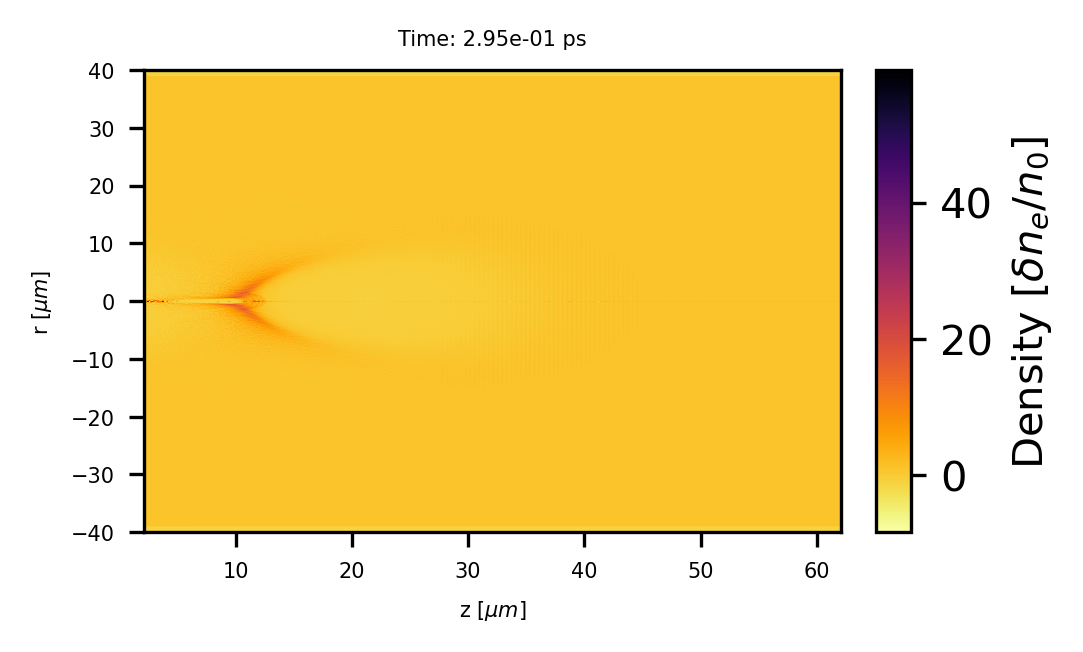

In [30]:
#####################################
fig_width = 3 # Set width to 1.5 inches
fig_height = 2  # Set height to 1.5 inches
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)
#charge_bg_dens = ax.pcolormesh(Z,X,rho_ele_dens.T,cmap='Spectral_r')
dens_map = ax.pcolormesh(Z *10**6, R*10**6, delta_tho_ele.T, cmap='inferno_r')
cb1 = add_colorbar(dens_map)
cb1.set_label(r'Density [$\delta n_e / n_0$]')
ax.set_title('Time: {:.2e} ps'.format(t*10**12),fontsize=5)
ax.tick_params('x',labelsize=5)
ax.tick_params('y',labelsize=5)
ax.set_ylabel(r'r [$\mu m$]', fontsize = 5)
ax.set_xlabel(r'z [$\mu m$]', fontsize = 5)
plt.show()

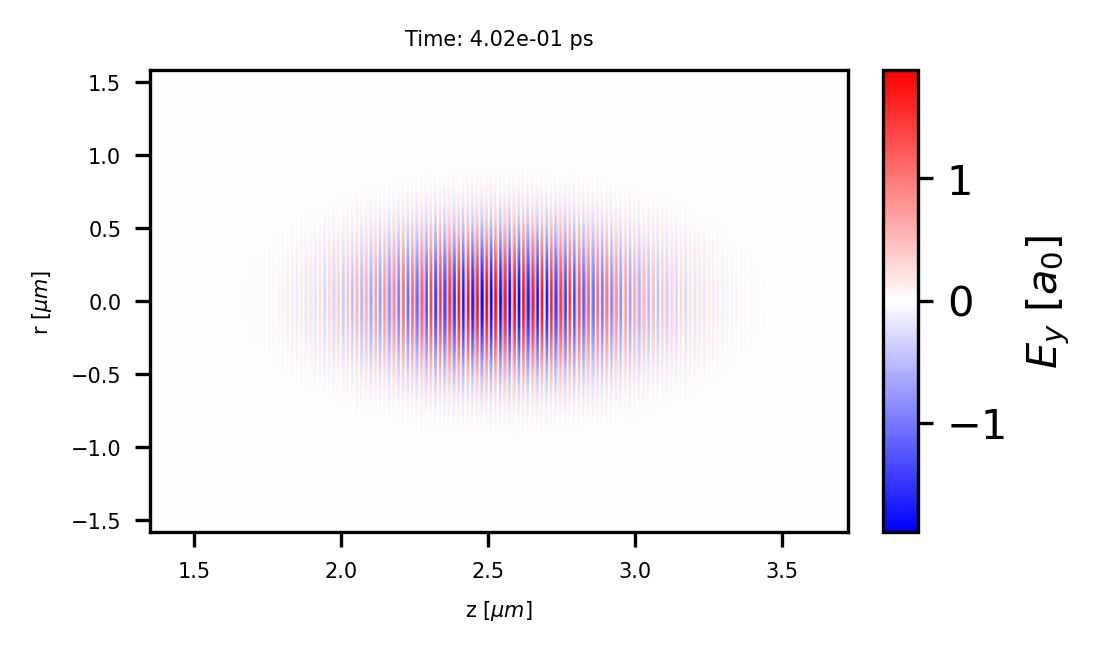

In [16]:
#####################################
fig_width = 3 # Set width to 1.5 inches
fig_height = 2  # Set height to 1.5 inches
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)
#charge_bg_dens = ax.pcolormesh(Z,X,rho_ele_dens.T,cmap='Spectral_r')
Ey_field = ax.pcolormesh(Z / lamp, R/lamp, Ey_norm.T, cmap='bwr')
cb1 = add_colorbar(Ey_field)
cb1.set_label('$E_y$ [$a_0$]')
ax.set_title('Time: {:.2e} ps'.format(t*10**12),fontsize=5)
ax.tick_params('x',labelsize=5)
ax.tick_params('y',labelsize=5)
ax.set_ylabel(r'r [$\mu m$]', fontsize = 5)
ax.set_xlabel(r'z [$\mu m$]', fontsize = 5)
plt.show()